In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
import spyrit.misc.walsh_hadamard as wh

# from spyrit.misc.statistics import stat_walsh_stl10
from spyrit.misc.statistics import *
from spyrit.misc.disp import *

In [2]:
img_size = 64 # image size
M = 512    # number of measurements
N0 = 50    # Image intensity (in photons)
bs = 10 # Batch size

#- Model and data paths
data_root = Path('../../data/')
stats_root = Path('../../data/stats_walsh')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size


Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Hperm = Perm@H;
Pmat = Hperm[:M,:];


In [6]:
x = inputs.view(b*c,w*h)
x_0 = torch.zeros_like(x)

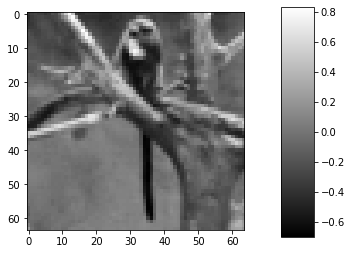

In [7]:
img = x[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

In [8]:
from spyrit.restructured.Updated_Had_Dcan import * 

In [9]:
FO_split_had = Split_Forward_operator_ft_had(Pmat, Perm)
Acq = Bruit_Poisson_approx_Gauss(N0, FO_split_had)
PreP = Split_diag_poisson_preprocess(N0, M, w*h)
DC_layer = Generalized_Orthogonal_Tikhonov(sigma_prior = Cov, M = M, N = h*w)
Denoi = ConvNet()

In [10]:
model = DC_Net(Acq, PreP, DC_layer, Denoi)

In [11]:
inputs.shape

torch.Size([10, 1, 64, 64])

In [12]:
outputs = model(inputs)

In [13]:
outputs.shape

torch.Size([10, 1, 64, 64])

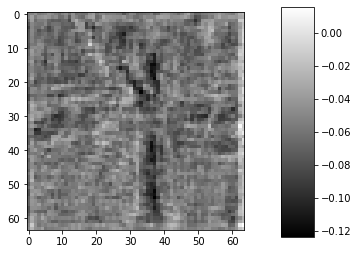

In [14]:
img = outputs[1,0,:,:]
img = torch2numpy(img);
imagesc(np.reshape(img,(h,w)))

In [15]:
outputs = model.forward_mmse(inputs)

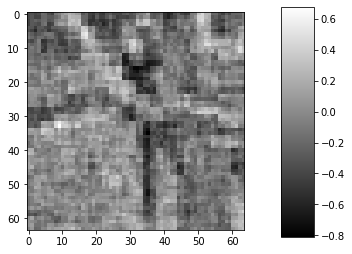

In [16]:
img = outputs[1,0,:,:]
img = torch2numpy(img);
imagesc(np.reshape(img,(h,w)))

In [17]:
model

DC_Net(
  (Acq): Bruit_Poisson_approx_Gauss(
    (FO): Split_Forward_operator_ft_had(
      (Hsub): Linear(in_features=4096, out_features=512, bias=False)
      (Hsub_adjoint): Linear(in_features=512, out_features=4096, bias=False)
      (Hpos_neg): Linear(in_features=4096, out_features=1024, bias=False)
      (Perm): Linear(in_features=4096, out_features=4096, bias=False)
    )
  )
  (PreP): Split_diag_poisson_preprocess()
  (DC_layer): Generalized_Orthogonal_Tikhonov(
    (comp): Linear(in_features=512, out_features=3584, bias=False)
    (denoise_layer): Denoise_layer(in_features=512)
  )
  (Denoi): ConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

In [18]:
x = inputs.view(b*c,w*h)
m = Acq(x)
m = m.view(b,c, 2*M)
outputs = model.reconstruct(m)

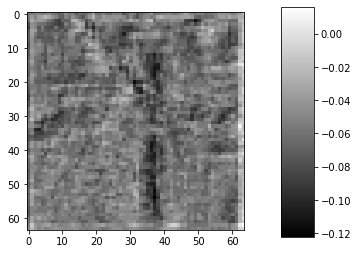

In [19]:
img = outputs[1,0,:,:]
img = torch2numpy(img);
imagesc(np.reshape(img,(h,w)))

In [20]:
from spyrit.learning.nets import load_net
title = "../../models/new_models/DC_Net__N0_10_N_64_M_512_epo_2_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
load_net(title, model, device)

Model Loaded: ../../models/new_models/DC_Net__N0_10_N_64_M_512_epo_2_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


In [21]:
outputs = model(inputs)

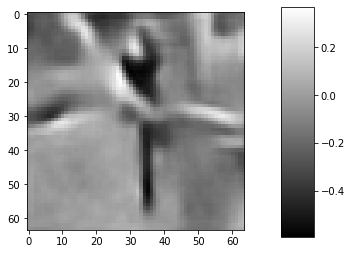

In [22]:
img = outputs[1,0,:,:]
img = torch2numpy(img);
imagesc(np.reshape(img,(h,w)))